In [1]:
import pandas as pd
import numpy as np
import os
import json 
import sys
from typing import Dict, Tuple, Any, Optional, List
sys.path.append('..')
import time
from src.utils import load_data

c:\Users\1\anaconda3\envs\rag\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_antique = load_data('../data/antique/all.json')

In [47]:
df_antique.to_json('../data/antique/all.json', orient='records', lines=True)

## reeval

In [14]:
NORMAL_INSTRUCTION = """Please act as an impartial judge and evaluate the quality of the response provided by an AI assistant to the user question displayed below. Your evaluation should consider factors such as the helpfulness, relevance, accuracy, depth, and level of detail of the response. Begin your evaluation by providing a short explanation. Be as objective as possible. After providing your explanation, please rate the response on a scale of 1 to 10 by strictly following this format: [[rating]], for example: Rating: [[5]].
"""
QA = """[Question]
{question}

[The Start of Assistant’s Answer]
{answer}
[The End of Assistant’s Answer]"""

In [17]:
def gen_prompt(question, answer, ref=None, system_instruction='', user_instruction=QA):
    if ref is not None:
        return [
            {"role": "system", "content": system_instruction.strip()},
            {"role": "user", "content": user_instruction.format(question=question, answer=answer, answer_ref=ref)}
        ]
    else:
        return [
            {"role": "system", "content": system_instruction.strip()},
            {"role": "user", "content": user_instruction.format(question=question, answer=answer)}
        ]
df = df_antique
normal_prompts = [gen_prompt(df['query'][i], df['answer'][i], df['doc'][i], system_instruction=NORMAL_INSTRUCTION) for i in range(len(df))]

In [18]:
sys.path.append(r'C:\Users\1\Documents\GitHub\rageval')
from rageval.models import OpenAILLM

In [20]:
from src.models import results_to_dict, get_score_and_re_eval, evaluate

models = ['claude-3-5-sonnet-20241022', 'gemini-2.0-flash-exp']
# model = 'gpt-4o'

# os.environ["MODEL"] = model
os.environ["BASE_URL"] = "https://www.dmxapi.com/v1"
os.environ["API_KEY"] = "sk-QrZV1bwbElxb97eMg3nbmm6HqkuobjxKAiEUKjgJnDmMoU81"

import time

prompts = normal_prompts
for model in models:
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    llm_evaluator = OpenAILLM(model=model, 
                              _api_key_env_var="API_KEY",
                              base_url=os.getenv("BASE_URL"),)

    results, texts = evaluate(llm_evaluator, prompts, cache_path=None, max_workers=16)
    scores, texts, results = get_score_and_re_eval(llm_evaluator, results, prompts, texts)
    
    with open(f"../data/run/wikieval_{model}_{timestamp}.json", "a+") as f:
         f.write(json.dumps([results_to_dict(r) for r in results]))
    
    if model == 'claude-3-5-sonnet-20241022':
        df['Claude-3.5'] = scores
    elif model == 'gemini-2.0-flash-exp':
        df['gemini-2.0'] = scores

Generating: 100%|██████████| 1386/1386 [04:16<00:00,  5.41it/s]


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
def draw_type_boxplot(df, rows=2,cols=5,metrics=['Human', 'Rouge-L', 'BERT Score', 
              'Answer Relevance Score', 'GPT-4o Fine-grained', 'GPT-4', 'Claude-3.5', 'gemini-2.0']):
    # Set up the figure with multiple subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
    # fig.suptitle(f'Relationship between Answer Length and Different Metrics on {dataset}', fontsize=16)

    # Create box plots
    for idx, metric in enumerate(metrics):
        row = idx // cols
        col = idx % cols
        # df['length_group'] = pd.qcut(df['answer_length'], q=5)
        # df['length_group'] = df['length_group'].cat.as_ordered()
        df = df.sort_values(by='category')

        sns.boxplot(data=df, x='category', y=metric, ax=axes[row, col], width=0.5)
        axes[row, col].set_xlabel('')
        axes[row, col].tick_params(axis='x', rotation=45)
        axes[row, col].set_ylabel(metric)
    # Remove empty subplots
    for idx in range(len(metrics), rows * cols):
        fig.delaxes(axes.flatten()[idx])
    plt.tight_layout()
    plt.show()


In [43]:
df_antique.columns

Index(['query_id', 'doc_id', 'relevance', 'iteration', 'query', 'doc',
       'answer', 'Answer Relevance Score', 'GPT-4 Score', 'GPT4 Accuracy',
       'GPT4 Informativeness', 'Human Accuracy', 'Human Informativeness',
       'Rouge-L', 'BERT Score', 'category', 'model', 'gpt4_cate_accuracy',
       'gpt4_cate_informativeness', 'GPT-4o Fine-grained', 'Human',
       'answer_length', 'claude-3.5', 'gemini-2.0'],
      dtype='object')

In [46]:
df_antique.rename(columns={'Answer Relevance Score':'Answer Relevance',
                           'claude-3.5': 'claude-3.5', 
                           'gemini-2.0': 'Gemini-2.0',
                           'GPT-4 Score':'GPT-4o',
                           'Rouge-L':'Rouge L',
                           }, inplace=True)

In [48]:
dfci = pd.DataFrame()
for c in df_antique.category.unique():
    m = df_antique[df_antique.category == c]
    dfci[c] = m[['Human', 'Answer Relevance', 'GPT-4o', 
       'Rouge L', 'BERT Score', 'GPT-4o Fine-grained','Claude-3.5','Gemini-2.0']].corr('kendall')['Human']
dfci

,REASON,EVIDENCE-BASED,INSTRUCTION,EXPERIENCE,COMPARISON,DEBATE
Human,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Answer Relevance,0.261406,0.095227,0.143913,0.231475,0.327022,0.363577
GPT-4o,0.688357,0.701155,0.739059,0.676877,0.771762,0.731017
Rouge L,-0.028842,-0.038889,-0.131835,-0.033793,-0.055111,-0.027844
BERT Score,-0.182057,-0.068286,-0.214897,-0.202429,-0.241215,-0.200215
GPT-4o Fine-grained,0.757832,0.739957,0.760208,0.710485,0.846998,0.784897
Claude-3.5,0.631066,0.581964,0.630524,0.549243,0.716192,0.622357
Gemini-2.0,0.553407,0.444380,0.520270,0.460994,0.542305,0.603226


In [35]:
dfc = pd.DataFrame()
for c in df_antique.category.unique():
    m = df_antique[df_antique.category == c]
    dfc[c] = m[['Human Informativeness', 'Answer Relevance Score', 'GPT-4 Score', 'GPT4 Accuracy',
       'GPT4 Informativeness',
       'Rouge-L', 'BERT Score', 'GPT-4o Fine-grained','Claude-3.5','gemini-2.0']].corr('kendall')['Human Informativeness']
dfc['avg'] = df_antique[['Human Informativeness', 'Answer Relevance Score', 'GPT-4 Score', 'GPT4 Accuracy',
       'GPT4 Informativeness',
       'Rouge-L', 'BERT Score', 'GPT-4o Fine-grained','Claude-3.5','gemini-2.0']].corr('kendall')['Human Informativeness']
dfc

,REASON,EVIDENCE-BASED,INSTRUCTION,EXPERIENCE,COMPARISON,DEBATE,avg
Human Informativeness,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Answer Relevance Score,0.276337,0.096143,0.165535,0.259347,0.375073,0.427760,0.228779
GPT-4 Score,0.719984,0.702035,0.730933,0.737915,0.809326,0.747392,0.727902
GPT4 Accuracy,0.646908,0.566545,0.592936,0.569990,0.638238,0.617155,0.604977
GPT4 Informativeness,0.790217,0.778708,0.793388,0.779041,0.854812,0.808936,0.792126
Rouge-L,-0.038055,-0.043386,-0.120693,-0.052048,-0.038548,-0.018186,-0.060946
BERT Score,-0.194365,-0.091019,-0.217172,-0.233504,-0.270391,-0.214273,-0.188049
GPT-4o Fine-grained,0.747391,0.693493,0.729447,0.714453,0.804154,0.744437,0.732460
claude-3.5,0.640125,0.632666,0.632366,0.566582,0.747728,0.596673,0.630222
gemini-2.0,0.549746,0.425267,0.502797,0.447610,0.539173,0.587459,0.492277


In [57]:
dfca = pd.DataFrame()
for c in df_antique.category.unique():
    m = df_antique[df_antique.category == c]
    dfca[c] = m[['Human Accuracy', 'Answer Relevance', 'GPT-4o', 'Rouge L', 'BERT Score', 'GPT-4o Fine-grained','Claude-3.5','Gemini-2.0']].corr('kendall')['Human Accuracy']
dfca['avg'] = df_antique[['Human Accuracy', 'Answer Relevance', 'GPT-4o', 'Rouge L', 'BERT Score', 'GPT-4o Fine-grained','Claude-3.5','Gemini-2.0']].corr('kendall')['Human Accuracy']
dfca

,REASON,EVIDENCE-BASED,INSTRUCTION,EXPERIENCE,COMPARISON,DEBATE,avg
Human Accuracy,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Answer Relevance,0.223571,0.088187,0.087954,0.165090,0.263752,0.258740,0.158296
GPT-4o,0.581990,0.587765,0.684087,0.524027,0.594258,0.632549,0.605984
Rouge L,0.016135,-0.022176,-0.123839,0.037294,-0.036979,-0.007881,-0.029617
BERT Score,-0.134781,-0.010851,-0.179676,-0.108815,-0.182501,-0.152336,-0.121815
GPT-4o Fine-grained,0.670513,0.664782,0.716569,0.611818,0.724786,0.711309,0.677993
Claude-3.5,0.569902,0.436054,0.590445,0.446645,0.562977,0.653566,0.543251
Gemini-2.0,0.536127,0.416771,0.530032,0.472100,0.479058,0.620682,0.498227


In [60]:
dfca.columns

Index(['REASON', 'EVIDENCE-BASED', 'INSTRUCTION', 'EXPERIENCE', 'COMPARISON',
       'DEBATE', 'avg'],
      dtype='object')

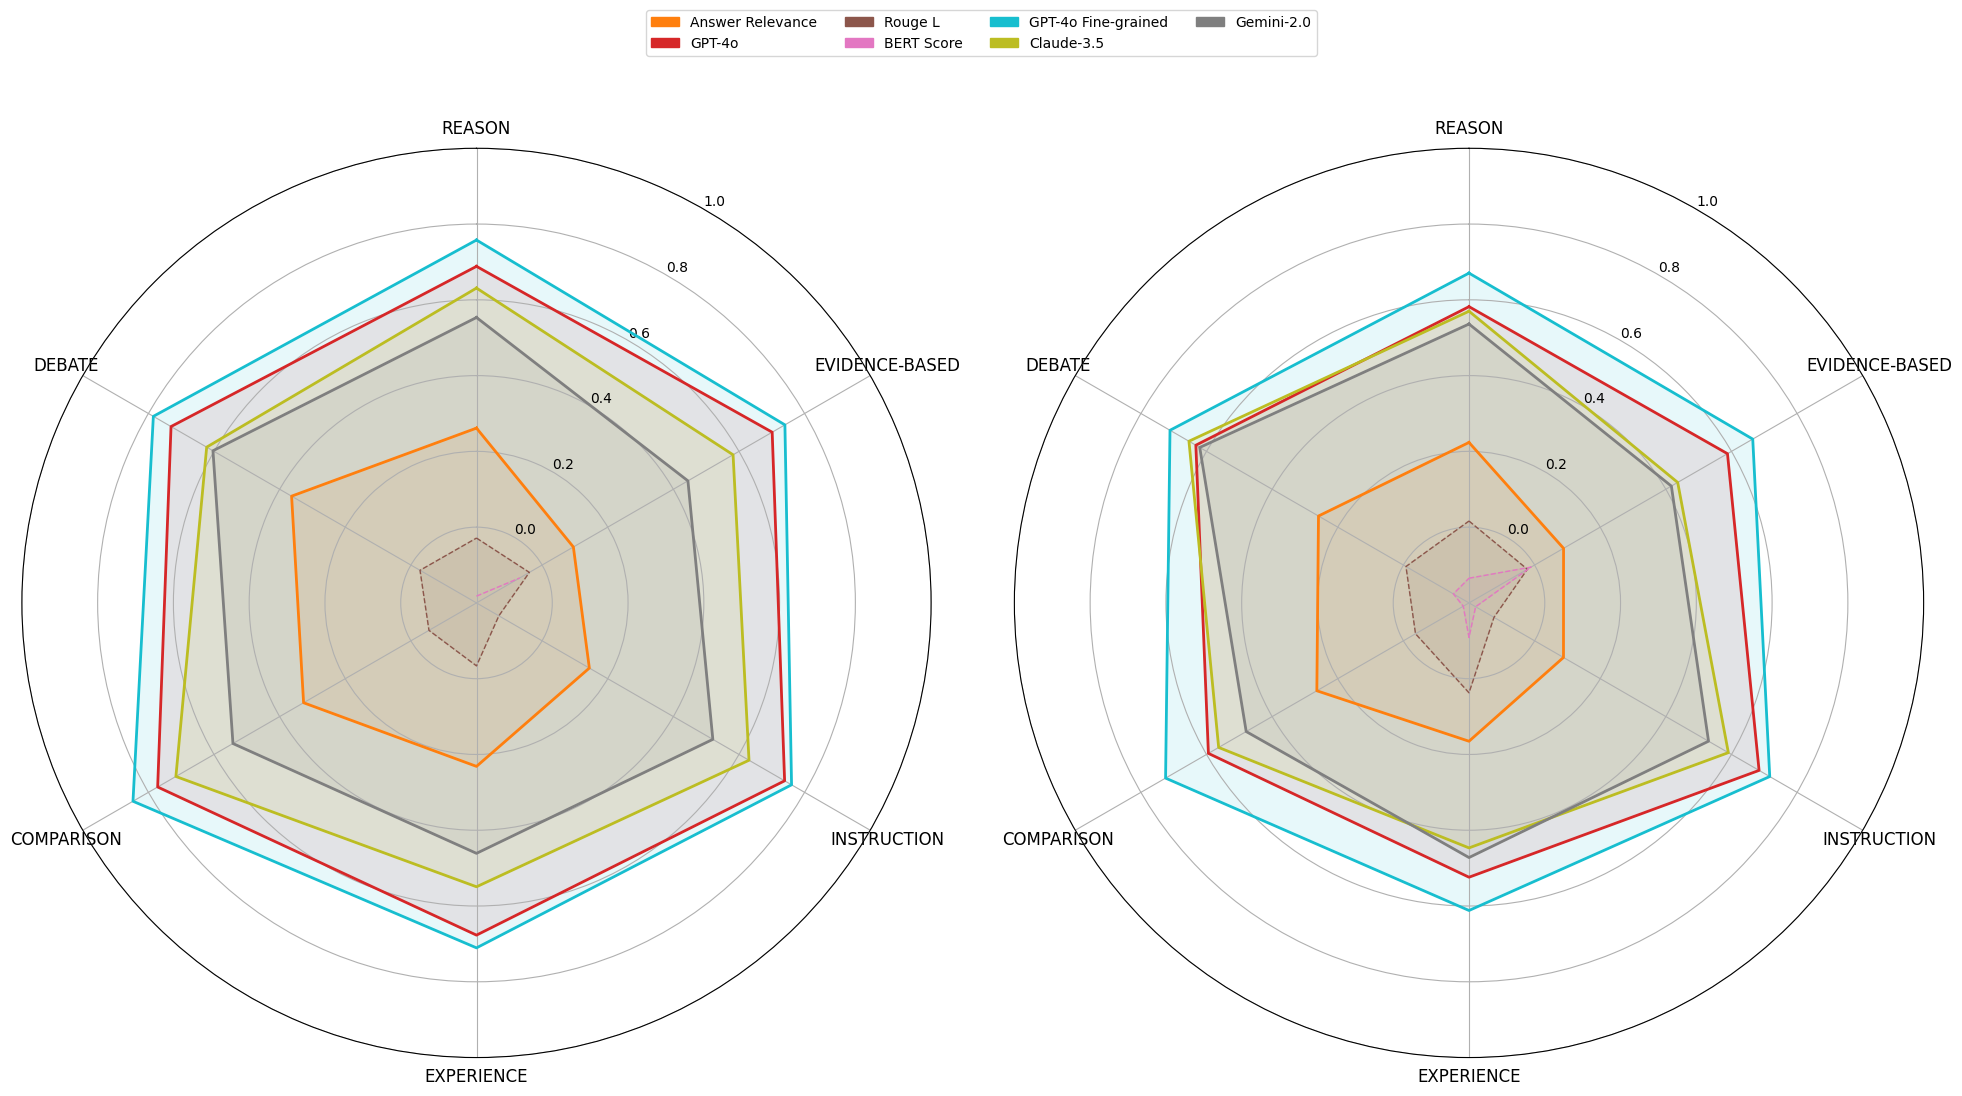

In [62]:
from matplotlib.patches import Patch
def radar_plot(df1, df2, label=True):
    df1 = df1[['REASON', 'EVIDENCE-BASED', 'INSTRUCTION', 'EXPERIENCE', 'COMPARISON', 'DEBATE']]
    df2 = df2[['REASON', 'EVIDENCE-BASED', 'INSTRUCTION', 'EXPERIENCE', 'COMPARISON', 'DEBATE']]
    categories = df1.columns.tolist()
    N = len(categories)
    
    # 角度计算
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # 闭合多边形
    
    # 创建画布
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'polar': True})
    
    # 颜色配置
    colors = {
        "Answer Relevance": "#ff7f0e",
        "GPT-4o": "#d62728",
        "Rouge L": "#8c564b",
        "BERT Score": "#e377c2",
        "GPT-4o Fine-grained": "#17becf",
        "Claude-3.5": "#bcbd22",
        "Gemini-2.0": "#7f7f7f"
    }
    
    # 绘制每个模型
    for model in df1.index:
        values = df1.loc[model].tolist()
        closed_values = values + values[:1]  # 数据闭环
        
        # 特殊处理负值区域
        if any(v < 0 for v in values):
            ax1.fill(angles, closed_values, alpha=0.1, color=colors[model])
            ax1.plot(angles, closed_values, color=colors[model], linestyle='--', linewidth=1, label=model)
        else:
            ax1.plot(angles, closed_values, color=colors[model], linewidth=2, label=model)
            ax1.fill(angles, closed_values, alpha=0.1, color=colors[model])
    
    for model in df2.index:
        values = df2.loc[model].tolist()
        closed_values = values + values[:1]  # 数据闭环
        
        # 特殊处理负值区域
        if any(v < 0 for v in values):
            ax2.fill(angles, closed_values, alpha=0.1, color=colors[model])
            ax2.plot(angles, closed_values, color=colors[model], linestyle='--', linewidth=1, label=model)
        else:
            ax2.plot(angles, closed_values, color=colors[model], linewidth=2, label=model)
            ax2.fill(angles, closed_values, alpha=0.1, color=colors[model])

    # 设置极坐标轴
    ax1.set_theta_offset(np.pi/2)  # 起始角度
    ax1.set_theta_direction(-1)    # 顺时针方向
    ax1.set_rlabel_position(30)    # 数值标签位置
    
    ax2.set_theta_offset(np.pi/2)  # 起始角度
    ax2.set_theta_direction(-1)    # 顺时针方向
    ax2.set_rlabel_position(30)    # 数值标签位置
    
    # 设置刻度标签
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(categories, fontsize=12)
    
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(categories, fontsize=12)
    
    # 设置半径轴范围（包含负值）
    ax1.set_ylim(-0.2, 1.0)
    ax2.set_ylim(-0.2, 1.0)

    # 添加图例
    if label:
        handles = [Patch(color=color, label=model) for model, color in colors.items()]
        fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4)

    # 添加标题
    # plt.title("Model Performance Radar Chart (with Anomaly Detection)", 
    #          y=1.15, fontsize=14, fontweight='bold')

    # 显示图形
    plt.tight_layout()
    plt.show()

# 执行绘图
radar_plot(dfci.iloc[1:], dfca.iloc[1:])

In [67]:
df_antique.model.unique()

array(['glm-4', 'llama2-13b-chat', 'gpt_3.5_turbo_instruct', 'mistral_7b',
       'llama2_7b_chat', 'llama3_8b_instruct', 'solar_10.7b_instruct'],
      dtype=object)

In [70]:
# 统计不同问题的数量和比例
m = df_antique.query('model == "glm-4"')
question_counts = m['category'].value_counts()
question_proportions = m['category'].value_counts(normalize=True)

# 创建一个新的 DataFrame 来存储统计结果
stats_df = pd.DataFrame({
    'Question': question_counts.index,
    'Count': question_counts.values,
    'Proportion': question_proportions.values
})

# 打印 LaTeX 表格
latex_table = stats_df.to_latex(index=False, float_format="%.2f")
print(latex_table)

\begin{tabular}{lrr}
\toprule
Question & Count & Proportion \\
\midrule
REASON & 61 & 0.31 \\
INSTRUCTION & 51 & 0.26 \\
EVIDENCE-BASED & 38 & 0.19 \\
EXPERIENCE & 22 & 0.11 \\
DEBATE & 15 & 0.08 \\
COMPARISON & 11 & 0.06 \\
\bottomrule
\end{tabular}



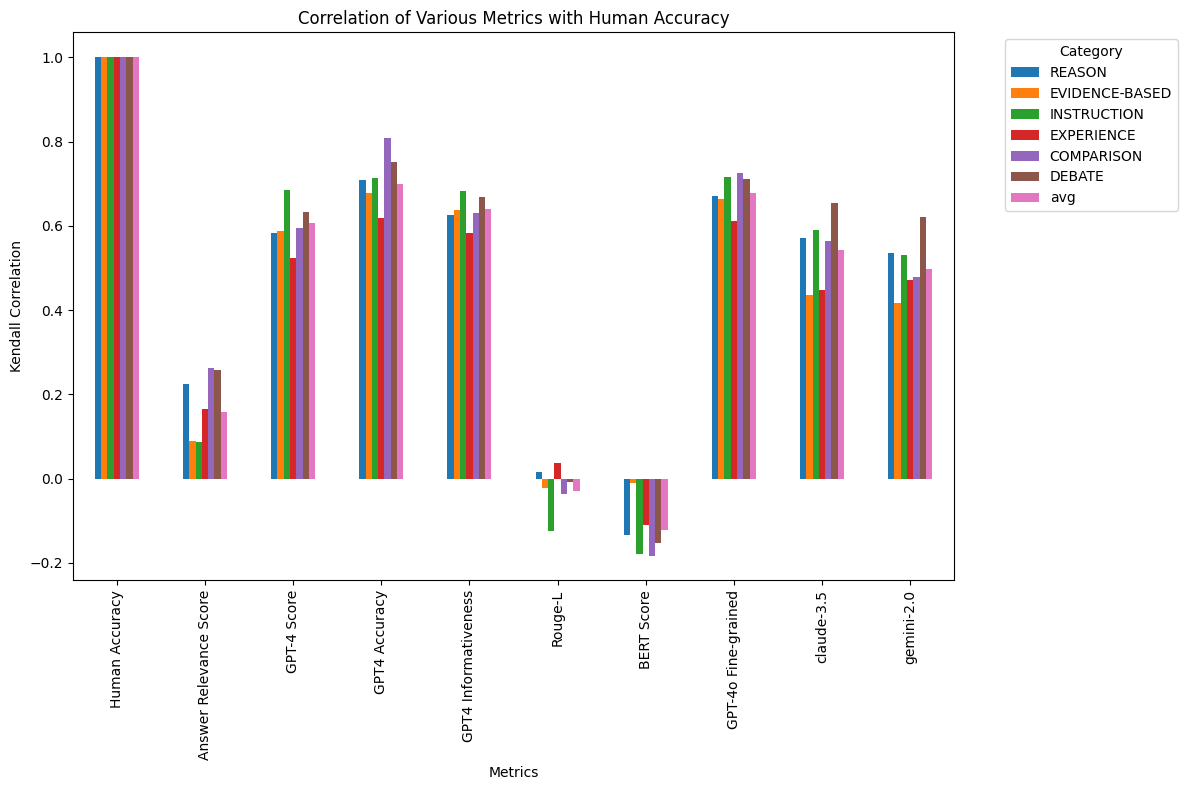

In [38]:
import matplotlib.pyplot as plt

# 绘制 dfc 的柱状图
dfc.plot(kind='bar', figsize=(12, 8))
plt.title('Correlation of Various Metrics with Human Accuracy')
plt.xlabel('Metrics')
plt.ylabel('Kendall Correlation')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

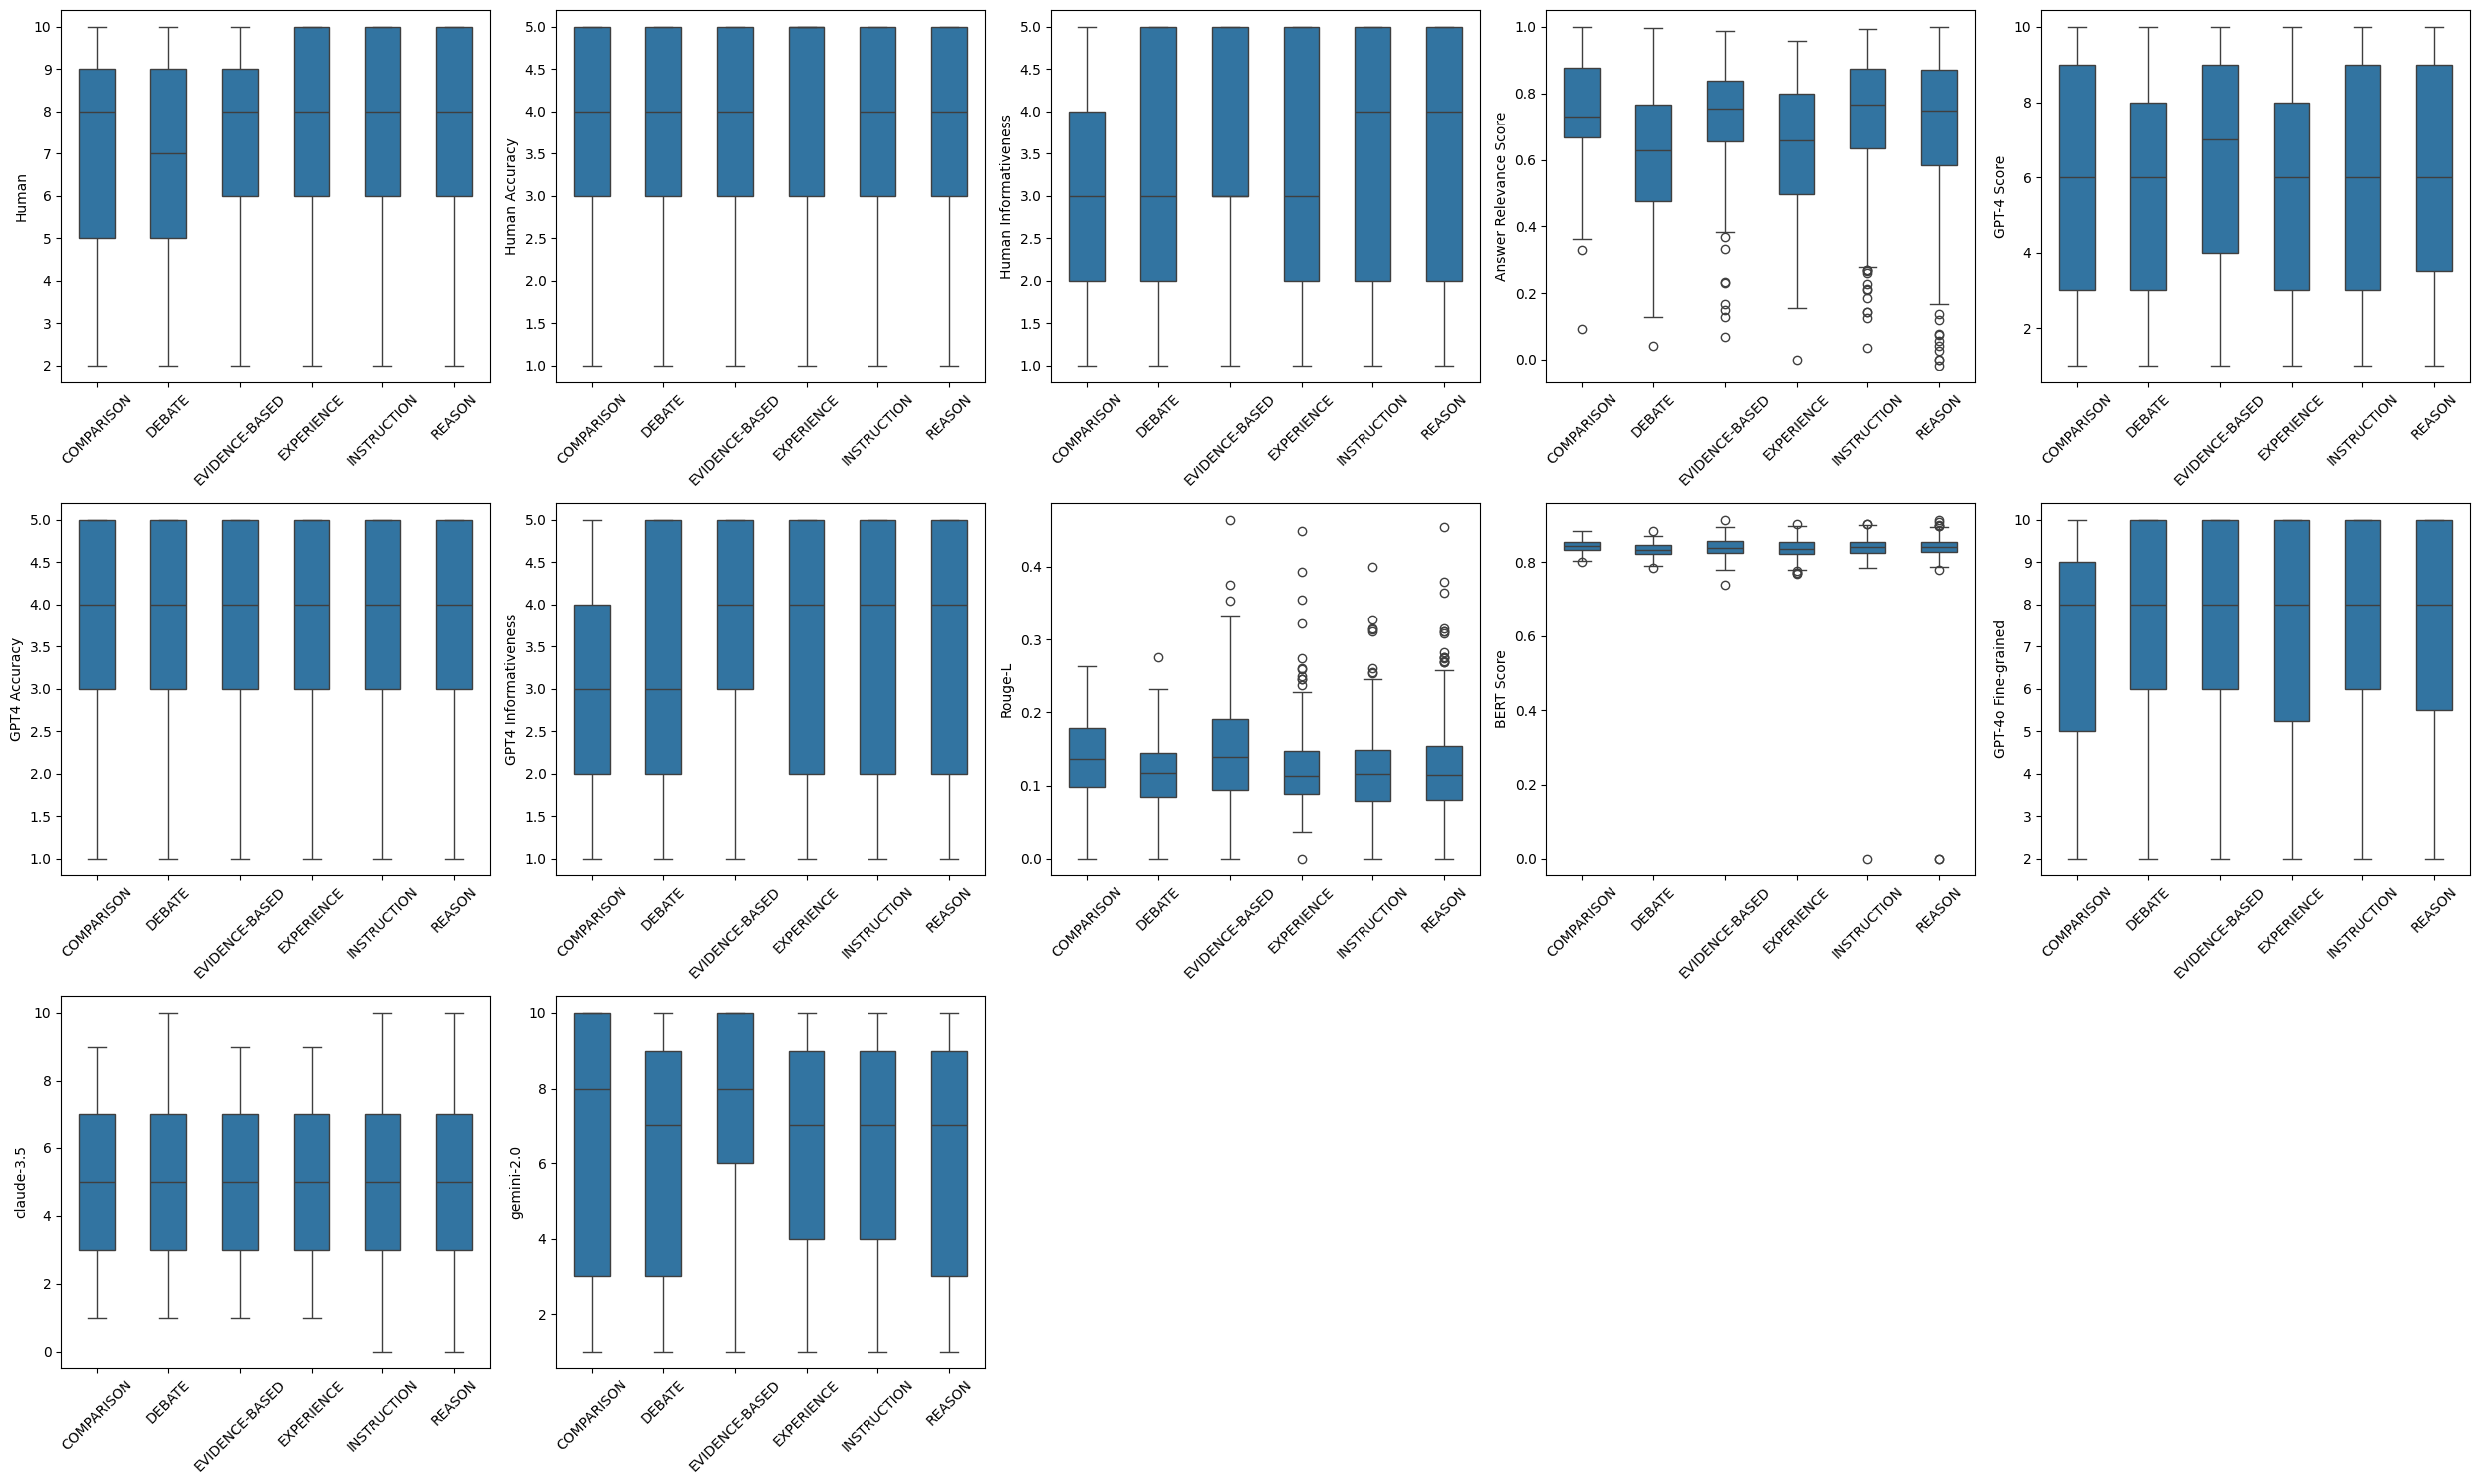

In [ ]:
draw_type_boxplot(df_antique, rows=3, cols=5, metrics=['Human', 'Human Accuracy', 'Human Informativeness', 'Answer Relevance Score', 'GPT-4 Score', 'GPT4 Accuracy', 'GPT4 Informativeness', 'Rouge-L', 'BERT Score', 'GPT-4o Fine-grained', 'claude-3.5', 'gemini-2.0'])